# EV Watts Analysis: SIADS 696 Milestone II Course
Group 17: Watt About Batteries (Matt Jones, Szymon Sarnowyz, Andrew Tunison)

---
### Background: 

In this Notebook, we explore which quantitative features should be considered for unsupervised learning. At this point we've already merged the data from the EVSE, Session, and Connector datasets and pre-processed by: removing entries with null values, extracting seasonal features from timestamp columns, and dropping unique identifier columns that specify the id of the specific connector, EVSE, or session.  

In total, we have 8 quantitative variables we could include in our unsupervised learning model as well as 8 categorical variables. However, when these categorical variables are One-Hot encoded and we extract the seasonal features extracted from the timestamp, the matrix grows to an mx68 array. Given the signiciant number of dimensions, we want to reduce as many features as possible to enable efficient model training. 

We'll begin by reviewing the quantitative features, to determine if we can reduce any feature representation based on very strong correlations (Corr >0.9) to other variables. If we do, we'll remove the features. Otherwise, we'll include them. Importantly though if features are removed, our model may lose the ability to consider interactions between features in the greater dimension space. We'll use the pearson correlation for our analysis

Let's get started: 

---
### Quantitative Asssessment

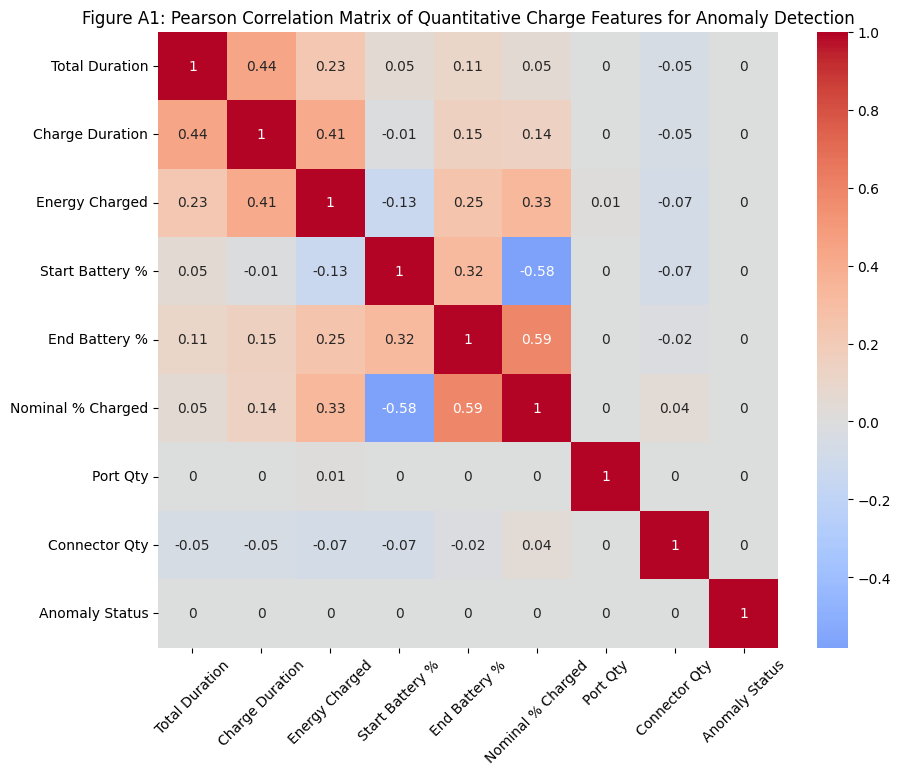

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

import Prep_data_UL_V2

def get_correlations(input_df): 
    
    #clip data coming in
    if len(input_df) > 250000: 
        input_df = input_df.sample(250000)

    #Separate phrases to consider
    cat_phrases = ["metro_area", "power_kw", "connector_type", "pricing", "region_", "land_use", "venue_", "charge_level"]
    time_phrases = ["day", "month", "year"] 

    #Get list of variable types
    quant_list = [item for item in input_df.columns if not any(phrase in item for phrase in cat_phrases)]
    quant_no_time = [item for item in quant_list if not any(phrase in item for phrase in time_phrases)]
    cat_list = [item for item in input_df.columns if item not in quant_list]

    #Prepare the dataframes
    quant_notime_df = input_df[quant_no_time]

    #Calculate correlations
    quant_notime_correlations = quant_notime_df.corr().round(2)

    #Clip where approximately 0
    quant_notime_correlations = np.where((quant_notime_correlations > -0.01) & (quant_notime_correlations < 0.01), 0, quant_notime_correlations)
    
    #Set names for columns to output
    quant_names_no_time = ["Total Duration", "Charge Duration", "Energy Charged", "Start Battery %", "End Battery %", "Nominal % Charged",
                          "Port Qty", "Connector Qty", "Anomaly Status"]
    
    
    #Update dataframes
    quant_notime_correlations = pd.DataFrame(quant_notime_correlations, index=quant_names_no_time, columns=quant_names_no_time)
        
    #Plot Correlation Matrices
    #Quant with time excluded
    plt.figure(figsize=(10, 8))
    sns.heatmap(quant_notime_correlations, annot=True, cmap="coolwarm", center=0)
    plt.title("Figure A1: Pearson Correlation Matrix of Quantitative Charge Features for Anomaly Detection")
    plt.xticks(rotation=45)
    plt.show()


if __name__ == "__main__":
    X_train, X_test, y_train, y_test = Prep_data_UL_V2.main_execution(input_condition=1)
    get_correlations(pd.concat([X_train, y_train], axis=1))

---
### Quantitative Discussion
While we see moderately strong correlations between some variables such as SOC_start (Start Battery (%)) and the Energy_kwh (Energy Charged), we do not see any quantitative variables whose correlations are strong enough that we would consider removing the values entirely. Also, on their own, it appears that none of the features could be directly used to infer anomaly status. Rather, the combined results of these features must be considered. While quantitative variables are all needed, we should consider if the same is true for the categorical variables. 

We'll do that using this part using the Cramer's V correlation. Given the column numbers and the calculation method involved, this is going to be a  computationally intensive process, so we're going to down-sample the data future just to gain an understanding of whether some of the categorical features should be removed. 

---
### Categorical Assessment
To evaluate whether categorical features should be included / excluded we'll utilize the Cramer's V correlation. We'll take the One-Hot encoded variables, and for each of the 60 variables, we'll compare the association between it and the other 60 variables in the dataset. Unlike Pearson's correlation, we should expect a value between 0 and +1 rather than -1 to 1. We'll implement a division handling case in the event that  

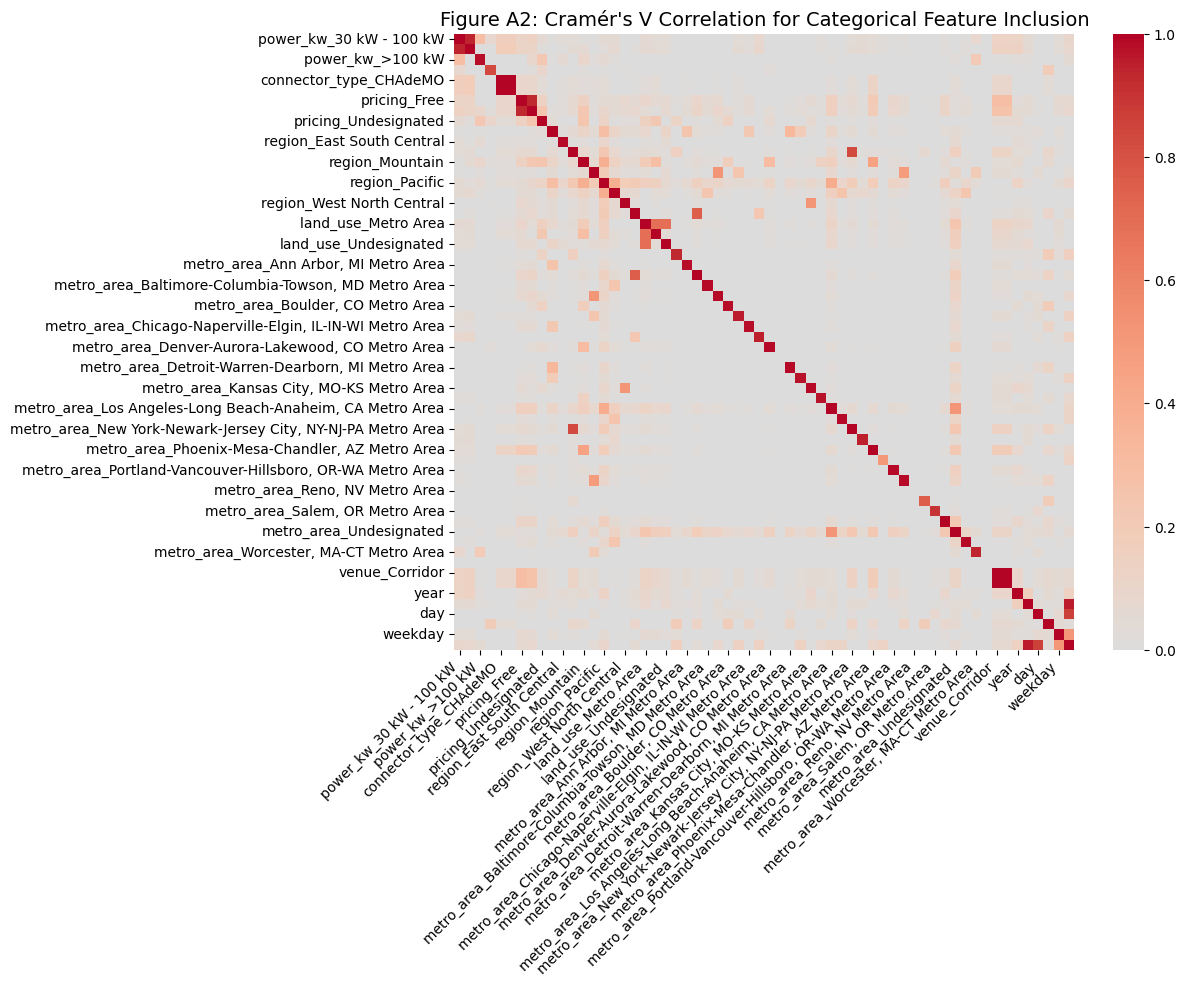

In [50]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)/(n-1)))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom == 0:  # Check for zero denominator
        return 0
    return np.sqrt(phi2corr / denom)

# Function to calculate Cramér's V for a DataFrame
def cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    cramers_v_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            confusion_matrix = pd.crosstab(df[cols[i]], df[cols[j]])
            cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
            cramers_v_matrix[j, i] = cramers_v_matrix[i, j]
    
    return pd.DataFrame(cramers_v_matrix, index=cols, columns=cols)


def get_cat_plot(input_df): 
    cat_phrases = ["metro_area", "power_kw", "connector_type", "pricing", "region_", "land_use", "venue_", "charge_level", "day", "month", "year"] 
    cat_features = [item for item in input_df.columns if any(phrase in item for phrase in cat_phrases)]
    cat_df = input_df[cat_features].sample(5000)
    
    cramers_v_corr_matrix = cramers_v_matrix(cat_df).round(2)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cramers_v_corr_matrix, annot=False, fmt='.2f', cmap="coolwarm", center=0)
    plt.xticks(rotation=45, ha='right')
    plt.title("Figure A2: Cramér's V Correlation for Categorical Feature Inclusion", fontsize=14)
    plt.show()

if __name__ == "__main__":
    get_cat_plot(X_train)

### Categorical Discussion: 
For us to remove/reject any categorical features, we should look for similar strong correlations between neighboring pairs. However, we must remember that the One-Hot Encoding makes it such that same parent-level attributes are broken into child-level features. When multi-selection is not plausible, this means that we could potentially remove 1 child-level feature from each categorical option with n=2 entries. For example, columns regarding connector type and venue can be reduced to boolean single columns since the connector type entry is either 'CHadeMO' or 'Combo' and the venue is either 'Corridor' or 'Undesignated'.

We should be cautious outside of this to remove strong correlations between different child, same parent features. However, if strong features were shown between different parent, different child features, this could be worth considering for feature removal. Our results show however, that only strong correlations (corr > 0.9) for *some* same-parent, different-child features. As such we'll retain all features and just condense Venue and connector type, resulting in a (mxn) data matrix with 58 categorical columns instead of the original 60. 

---
### Footnotes and attribution
1. Notebook created by Matt Jones for SIADS696 Milestone II Course Project, University of Michigan Ann Arbor
2. Cramer's V Correlation source code obtained, with modification from stack overflow: <br>https://stackoverflow.com/questions/78318955/corrected-cramers-v-results-in-division-by-zero-when-n-r
3. For more on Cramer's V correlation, refer to: <br>*Cramér, Harald. 1946. Mathematical Methods of Statistics. Princeton: Princeton University Press, page 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6 (table of content Archived 2016-08-16 at the Wayback Machine)*